<a href="https://www.kaggle.com/code/rubanzasilva/fast-ai-gradient-boosting?scriptVersionId=191598552" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Library Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv
/kaggle/input/mushroom_predicition_nn/pytorch/default/1/mushroom_prediction_model.pth


In [2]:
%pip install catboost
%pip install optuna
%pip install optuna_distributed
%pip install openfe
%pip install seaborn
%pip install xgboost
%pip install lightgbm
%pip install fastkaggle
%pip install h2o
%pip install -Uqq fastbook
%pip install polars
%pip install -q -U autogluon.tabular
%pip install autogluon
#ip install --upgrade pip
%pip install tqdm
%pip install wandb


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.5 MB/s eta 0:00:0000:01
  Attempting uninstall: distributed
    Found existing installation: distributed 2024.5.1
    Uninstalling distributed-2024.5.1:
      Successfully uninstalled distributed-2024.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rapids-dask-dependency 24.6.0a0 requires dask==2024.5.1, but you have dask 2024.7.0 which is incompatible.
rapids-dask-dependency 24.6.0a0 requires distributed==2024.5.1, but you have distributed 2024.7.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note

In [3]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,mean_squared_error, matthews_corrcoef
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score



#transformers and pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv





import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from optuna.samplers import TPESampler
import warnings


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp



from openfe import OpenFE, transform
from autogluon.tabular import TabularDataset, TabularPredictor

import h2o
from h2o.automl import H2OAutoML

import gc

from xgboost import plot_importance
import wandb


#from IPython.display import FileLink

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
#wandb.login()

In [5]:
path = Path('/kaggle/input/playground-series-s4e8/')
path

Path('/kaggle/input/playground-series-s4e8')

In [6]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')

# Dealing with NaN in stem-height

I noticed that the column stem-height has missing values in the test set which are not in the training set.

The issue is our tabular pandas object takes uses the function fillMissing to fill in our missing values for columns with continuous values. This can be filled in with the median, mode of that column, or a constant, with the default being the median value for that particular column. 

However, FillMissing is built to only deal with missing values in columns that already have missing values in your training set i.e. for stem-height, which has no missing vaklues in the train set but has missing values in the test set, FillMissing wont know how to deal with them and hence throws an error.

To resolve this, we can 

- We can create a NaN in that particular column so that FillMissing knows how to deal with missing values in that column when it sees them in the test set which is what i have done in this notebook.
See the code cell right below.
- We can also fill in the missing values in the test set with a value such as 0, etc.
- Finally,We could choose to remove the missing values rows from the test set

In [7]:
# Make a copy of the training dataframe to avoid modifying the original
train_df_with_nan = train_df.copy()

# Add a NaN value to a random row in the 'stem-height' column
random_index = np.random.choice(train_df_with_nan.index)
train_df_with_nan.loc[random_index, 'stem-height'] = np.nan

# Verify the NaN was added
print(train_df_with_nan['stem-height'].isna().sum())

1


# Data Pre-processing

### Define categorical and continous variables

I use the fastai [cont_cat_split](https://docs.fast.ai/tabular.core.html#cont_cat_split) function to separate my dataset variables into categorical and continous variables based of the cardinality of my column values.

We take an argument max card whose default is 20.If the number of unique values is above 20 (max_card value) for a particular column, that column is considered continous and vice versa.

In [8]:
cont_names,cat_names = cont_cat_split(train_df_with_nan, dep_var='class')
len(cat_names),len(cont_names)

(17, 3)

### Split into training and validation set

The [RandomSplitter](https://docs.fast.ai/data.transforms.html#randomsplitter) below separates the training set into a training and validation set based off the value of the argument valid_pct.

In [9]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df_with_nan))

### TabularPandas

Below we define a [TabularPandas](https://docs.fast.ai/tabular.core.html#tabularpandas) object. 

Here we declare the continous and categorical columns, the dataset splitting strategy, preprocessing steps to apply to our datasets, the dependent variable which is what we are predicting and the type of problem we are optimizing for such as binary classification in this case.

In [10]:
to = TabularPandas(train_df_with_nan, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='class',
                   y_block=CategoryBlock(),
                   splits=splits)

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

### DataLoaders

We define a dataloaders which prepares our data for input into our neural network.Here we can define our batch size.

In [11]:
dls = to.dataloaders(bs=64)
#dls = to.dataloaders(bs=1024)
test_dl = dls.test_dl(test_df)

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [12]:
dls

In [13]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [14]:
X_train

,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,cap-diameter_na,stem-height_na,cap-diameter,stem-height,stem-width
id,,,,,,,,,,,,,,,,,,,,,,
547711,72,60,62,9,45,0,49,0,0,56,0,0,6,19,23,30,1,1,1,-0.948561,-0.851246,-1.081126
303590,72,56,64,9,53,0,60,0,59,56,20,22,19,28,0,26,3,1,1,0.451292,0.741772,0.548564
2524055,54,82,64,9,45,32,49,0,55,47,0,0,6,19,0,31,3,1,1,-1.040883,-0.380750,-0.940273
2096058,49,77,75,9,53,29,60,0,59,56,0,0,19,18,0,26,3,1,1,0.230150,2.197716,0.090175
2055442,49,77,64,9,76,29,49,0,44,39,0,0,6,19,0,26,3,1,1,-0.538481,-0.380750,-0.899500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175917,72,57,67,9,0,29,60,0,0,56,20,22,19,20,0,26,1,1,1,0.595142,1.853180,0.869807
486908,54,65,64,9,45,29,62,0,44,47,0,0,19,0,0,26,3,1,1,-0.154166,-0.506710,-0.646212
1072035,54,73,56,9,67,0,62,0,0,47,0,0,6,19,0,26,4,1,1,1.823235,-0.732696,2.969005


# Neural Network

Below we define a tabular_learner which is an extension of the learner class but specific for tabular data. A learner contains everything needed to train the model.

In [15]:
emb_szs = {
    var: int(min(64, round(1.6 * len(to.classes[var]) ** .56)))
    for var in to.cats.columns
}
emb_szs

{'cap-shape': 18,
 'cap-surface': 19,
 'cap-color': 18,
 'does-bruise-or-bleed': 10,
 'gill-attachment': 18,
 'gill-spacing': 14,
 'gill-color': 16,
 'stem-root': 12,
 'stem-surface': 16,
 'stem-color': 16,
 'veil-type': 9,
 'veil-color': 10,
 'has-ring': 9,
 'ring-type': 13,
 'spore-print-color': 11,
 'habitat': 15,
 'season': 4,
 'cap-diameter_na': 3,
 'stem-height_na': 3}

In [16]:
learn = tabular_learner(
    dls,
    emb_szs=emb_szs,
    layers=[200, 100],
    config=dict(ps=[0.3, 0.3],embed_p=0.3),
    metrics=MatthewsCorrCoef())

SuggestedLRs(slide=0.015848932787775993, valley=0.001737800776027143)

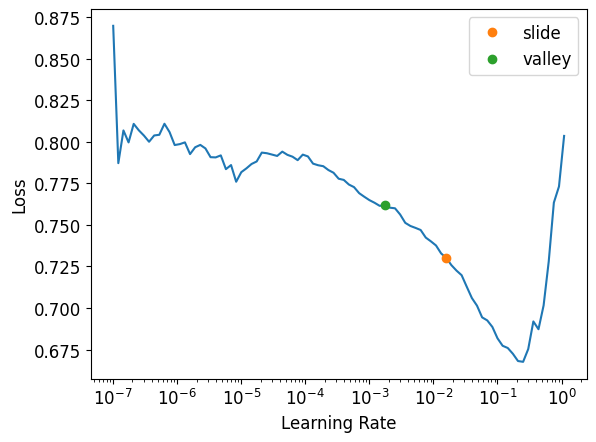

In [17]:
learn.lr_find(suggest_funcs=(slide,valley))

In [17]:
%%time
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,matthews_corrcoef,time
0,0.057328,0.043750,0.981656,08:54
1,0.056756,0.041780,0.982054,08:51
2,0.051143,0.041199,0.982390,08:51
3,0.053037,0.040822,0.982545,08:56
4,0.060734,0.039970,0.982791,08:39
5,0.049635,0.040551,0.982903,08:38
6,0.047585,0.039590,0.983134,08:38
7,0.044440,0.039581,0.983082,08:42
8,0.044342,0.039374,0.983214,08:41
9,0.042497,0.039619,0.983110,08:37


CPU times: user 1h 26min 45s, sys: 28.9 s, total: 1h 27min 14s
Wall time: 1h 27min 32s


In [ ]:
#learn = tabular_learner(dls, metrics=MatthewsCorrCoef())
#learn.fit_one_cycle(10)

In [ ]:
#learn.fit_one_cycle(10)

In [18]:
dl = test_dl
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)
nn_preds_proba_b = (a_preds[:, 1])

In [19]:
nn_preds_x.shape,nn_preds_y.shape

(torch.Size([623389, 2]), torch.Size([2077964, 2]))

In [20]:
nn_preds_x.shape

torch.Size([623389, 2])

In [21]:
nn_preds_x

tensor([[9.8777e-01, 1.2235e-02],
        [9.9901e-01, 9.9295e-04],
        [9.9861e-01, 1.3861e-03],
        ...,
        [9.9986e-01, 1.3516e-04],
        [2.9259e-03, 9.9707e-01],
        [2.8319e-03, 9.9717e-01]])

In [22]:
final_preds_scoring = nn_preds_x[:, 1]

In [23]:
final_preds_scoring.shape

torch.Size([623389])

In [24]:
rounded_nn_scoring_preds = torch.round(final_preds_scoring).long()
rounded_nn_scoring_preds

tensor([0, 0, 0,  ..., 0, 1, 1])

In [34]:
nn_score = matthews_corrcoef(y_test,rounded_nn_scoring_preds)
print(f"Final Neural Network MCC on test set: {nn_score}")

Final Neural Network MCC on test set: 0.9831102240320998


Final Neural Network MCC on test set: 0.9831102240320998


In [26]:
final_preds = nn_preds_y[:, 1]

In [27]:
final_preds.shape

torch.Size([2077964])

In [32]:
final_preds

tensor([0.0018, 0.9994, 0.9932,  ..., 0.9971, 0.0030, 0.0024])

In [33]:
learn.save('mushroom_prediction_model_cl')

Path('models/mushroom_prediction_model_cl.pth')

In [ ]:
#learn.load('mushroom_prediction_nn')

In [ ]:
!rm submission.csv

In [ ]:
rounded_nn_sub_preds = torch.round(final_preds).long()
rounded_nn_sub_preds

In [ ]:
#mapping = dict(enumerate(dls.vocab))
#submit = pd.read_csv(path/'sample_submission.csv')
#submit['class'] = [mapping[pred.item()] for pred in rounded_nn_sub_preds]
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#print(sub)

# XGBoost

In [ ]:
#%%time
"""
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 25),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'max_leaves': trial.suggest_int('max_leaves', 0, 1000),
        #'max_bin': trial.suggest_int('max_bin', 200, 1000),
        #'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        #'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        #'tree_method': trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        #'use_label_encoder': False,
        #'eval_metric': 'logloss',
        'device': 'gpu',
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50)
    }
    
    K_FOLDS = 5  # Number of folds for cross-validation
    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_scores = []
    
    #for train_index, test_index in kfold.split(train_df):
    #print(f'train: {len(train_index)} samples, test: {len(test_index)} samples')

    for train_index, val_index in kfold.split(X_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Train the model on the current fold
        
        xgb_model_fold = xgb.XGBClassifier(**params)
        xgb_model_fold.fit(X_fold_train, y_fold_train)
        
        # Predict probabilities on the validation set for the current fold
        y_pred_fold = xgb_model_fold.predict(X_fold_val)
        y_pred_fold_tt = xgb_model_fold.predict(test_dl.xs)
        
        # Calculate and store the AUC-ROC score for the current fold
        score = matthews_corrcoef(y_fold_val, y_pred_fold)
        fold_scores.append(score)
        
        # Calculate the average score across all folds
        return np.mean(fold_scores)

# Create and run the study
study = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=0), direction="maximize")
study.optimize(objective, n_trials=100)

print('Best value:', study.best_value)
print('Best trial:', study.best_trial.params)

"""


In [ ]:
#%%time

"""

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50)
    }
    
    K_FOLDS = 5  # Number of folds for cross-validation
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_scores = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Train the model on the current fold
        xgb_model_fold = xgb.XGBClassifier(**params)
        xgb_model_fold.fit(X_fold_train, y_fold_train)
        
        # Predict on the validation set for the current fold
        y_pred_fold = xgb_model_fold.predict(X_fold_val)
        
        # Calculate and store the Matthews Correlation Coefficient for the current fold
        score = matthews_corrcoef(y_fold_val, y_pred_fold)
        fold_scores.append(score)
        
        print(f"Fold {fold} MCC: {score}")

    # Return the average score across all folds
    mean_score = np.mean(fold_scores)
    print(f"Mean MCC: {mean_score}")
    return mean_score

# Create and run the study
study = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=0), direction="maximize")
study.optimize(objective, n_trials=100)

print('Best value:', study.best_value)
print('Best trial:', study.best_trial.params)

"""


In [ ]:
#print('Best value:', study.best_value)
#print('Best trial:', study.best_trial.params)

In [ ]:
optuna_params = {
              
    'num_leaves': 375, 
    'learning_rate': 0.0071851097672265855, 
    'n_estimators': 1851, 
    'subsample_for_bin': 104472,
    'min_child_samples': 454,
    'reg_alpha': 0.0011093389440775324,
    'reg_lambda': 0.15936937364526085,
    'colsample_bytree': 0.4533510196891779,
    'subsample': 0.9272807625455266,
    'max_depth': 20,
    'min_child_weight': 4,
    'gamma': 0.0033558210410357075,
    'max_leaves': 873,
    'device': 'gpu'
}


In [38]:
optuna_params = {
              
    'num_leaves': 375, 
    'learning_rate': 0.0071851097672265855, 
    'n_estimators': 10000, 
    'subsample_for_bin': 104472,
    'min_child_samples': 454,
    'reg_alpha': 0.0011093389440775324,
    'reg_lambda': 0.15936937364526085,
    'colsample_bytree': 0.4533510196891779,
    'subsample': 0.9272807625455266,
    'max_depth': 20,
    'min_child_weight': 4,
    'gamma': 0.0033558210410357075,
    'max_leaves': 873,
    'device': 'gpu'
}


In [39]:
%%time
xgb_model = xgb.XGBClassifier(**optuna_params)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

xgb_score = matthews_corrcoef(y_test,xgb_preds_x)
print(f"Final XGB MCC on test set: {xgb_score}")

Final XGB MCC on test set: 0.9843799565934216
CPU times: user 9min 25s, sys: 5.48 s, total: 9min 31s
Wall time: 9min 27s


In [37]:
print(f"Final XGB MCC on test set: {xgb_score}")

Final XGB MCC on test set: 0.9847231336182692


In [ ]:
!ls

In [ ]:
#mapping = dict(enumerate(dls.vocab))
#submit = pd.read_csv(path/'sample_submission.csv')
#submit['class'] = [mapping[pred.item()] for pred in xgb_preds]
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#print(sub)

# LGBM

In [ ]:
%%time
"""

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'device_type': 'gpu'
    }
    
    K_FOLDS = 5  # Number of folds for cross-validation
    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_scores = []
    
    #for train_index, test_index in kfold.split(train_df):
    #print(f'train: {len(train_index)} samples, test: {len(test_index)} samples')

    for train_index, val_index in kfold.split(X_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Train the model on the current fold
        lgb_model_fold = lgb.LGBMClassifier(**params)  # Use params, not lgbm_params
        lgb_model_fold.fit(X_fold_train, y_fold_train)
        
        y_pred_fold = lgb_model_fold.predict(X_fold_val)
        y_pred_fold_tt = lgb_model_fold.predict(test_dl.xs)
        
        # Calculate and store the AUC-ROC score for the current fold
        score = matthews_corrcoef(y_fold_val, y_pred_fold)
        fold_scores.append(score)
        
        # Calculate the average score across all folds
        return np.mean(fold_scores)

# Create and run the study
study = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=0), direction="maximize")
study.optimize(objective, n_trials=100)

print('Best value:', study.best_value)
print('Best trial:', study.best_trial.params)

"""


In [ ]:
#print('Best value:', study.best_value)
#print('Best trial:', study.best_trial.params)

In [ ]:
#%%time
"""

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'device_type': 'gpu'
    }
    
    K_FOLDS = 5  # Number of folds for cross-validation
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    fold_scores = []
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Train the model on the current fold
        lgb_model_fold = lgb.LGBMClassifier(**params)
        lgb_model_fold.fit(X_fold_train, y_fold_train)
        
        y_pred_fold = lgb_model_fold.predict(X_fold_val)
        
        # Calculate and store the MCC score for the current fold
        score = matthews_corrcoef(y_fold_val, y_pred_fold)
        fold_scores.append(score)
    
    # Calculate the average score across all folds
    return np.mean(fold_scores)

# Create and run the study
study = optuna.create_study(sampler=optuna.samplers.TPESampler(n_startup_trials=30, multivariate=True, seed=0), direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print('Best value:', study.best_value)
print('Best trial:', study.best_trial.params)
"""


In [ ]:
#print('Best value:', study.best_value)
#print('Best trial:', study.best_trial.params)

In [ ]:
#%%time
"""
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'device_type': 'gpu'
    }
    
    K_FOLDS = 5  # Number of folds for cross-validation
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    fold_scores = []
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Train the model on the current fold with early stopping
        lgb_model_fold = lgb.LGBMClassifier(**params)
        lgb_model_fold.fit(
            X_fold_train, y_fold_train,
            eval_set=[(X_fold_val, y_fold_val)],
            callbacks=[
                #LightGBMPruningCallback(trial, 'binary_logloss'),
                lgb.early_stopping(stopping_rounds=50, verbose=False)
            ]
        )
        
        y_pred_fold = lgb_model_fold.predict(X_fold_val)
        #y_pred_fold_tt = lgb_model_fold.predict(test_dl.xs)
        
        # Calculate and store the MCC score for the current fold
        score = matthews_corrcoef(y_fold_val, y_pred_fold)
        fold_scores.append(score)
    
    # Calculate the average score across all folds
    return np.mean(fold_scores)

# Create and run the study with a progress bar
study = optuna.create_study(sampler=optuna.samplers.TPESampler(n_startup_trials=30, multivariate=True, seed=0), direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print('Best value:', study.best_value)
print('Best trial:', study.best_trial.params)
"""